# 3 - AlexNet

In this notebook we will be implementing a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

![](assets/alexnet.png)

Confusingly, there are two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. Almost all implementations of AlexNet are now on a single GPU and our implementation is too.

We are now moving on from the MNIST dataset and from now on we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)

We will also show how to intialize the weights of our neural network and how to find a suitable learning rate using a modified version of the [learning rate finder](https://arxiv.org/abs/1506.01186).

Like the previous notebooks we'll implement our model, measure its performance on the dataset, and then have a short look into seeing what the model has learned.

Most of this notebook will be similar to the previous ones thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need. A new import is the `_LRScheduler` which we will use to implement our learning rate finder.

In [310]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
# import tensorflow as tf
import tensorboard as tb

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import copy
import random
import time
REG_method="mixup"
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [311]:
def random_seed(i=0):
  torch.manual_seed(i)
  np.random.seed(i)
  random.seed(i)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def rand_bbox(size, lam):
  W = size[2]
  H = size[3]
  cut_rat = np.sqrt(1. - lam)
  cut_w = np.int(W * cut_rat)
  cut_h = np.int(H * cut_rat)

  # uniform
  cx = np.random.randint(W)
  cy = np.random.randint(H)

  bbx1 = np.clip(cx - cut_w // 2, 0, W)
  bby1 = np.clip(cy - cut_h // 2, 0, H)
  bbx2 = np.clip(cx + cut_w // 2, 0, W)
  bby2 = np.clip(cy + cut_h // 2, 0, H)

  return bbx1, bby1, bbx2, bby2

def cutmix(image_batch, label_batch):
  lam = np.random.uniform()

  rand_index = torch.randperm(image_batch.size()[0]).to(DEVICE)
  target_a = label_batch
  target_b = label_batch[rand_index]
  
  bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)
  image_batch[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]

  lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.size()[-1] * image_batch.size()[-2]))
  return image_batch, target_a, target_b, lam

def mixup(image_batch, label_batch):
  lam = np.random.uniform()

  batch_size = image_batch.size()[0]
  index = torch.randperm(batch_size).to(DEVICE)

  image_batch = lam * image_batch + (1 - lam) * image_batch[index, :]
  target_a, target_b = label_batch, label_batch[index]
  return image_batch, target_a, target_b, lam

def cutout(image_batch, label_batch):
  lam = np.random.uniform()
  bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)

  mask = torch.ones_like(image_batch)
  mask[:, :, bbx1:bbx2, bby1:bby2] = 0

  image_batch = image_batch * mask.to(DEVICE)
  return image_batch, label_batch

In [312]:

# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [313]:
writer = SummaryWriter()

We set the random seed so all of our experiments can be reproduced.

In [314]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently. 

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [315]:
ROOT = '.data'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation. 

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [316]:
# train_transforms = transforms.Compose([
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                            transforms.RandomCrop(32, padding = 2),
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean = means, 
#                                                 std = stds)
#                        ])

# test_transforms = transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize(mean = means, 
#                                                 std = stds)
#                        ])

train_transforms = transforms.Compose([
                           transforms.ToTensor()
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor()
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [317]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)


test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


...create a validation set from our training set...

In [318]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

...and ensure our validation set uses the test transforms.

In [319]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We print out the number of examples in each set of data to ensure everything has gone OK so far.

In [320]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to `permute` our images before plotting them.

Ignore the `normalize` argument for now, we'll explain it shortly.

In [321]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

When we plot them we see lots of warnings. This is because `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated.

In [322]:
# type(np.array(images[0]))
type(images)

tuple

In [323]:
torch.stack(images,dim=0).shape

torch.Size([25, 3, 32, 32])

In [324]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [325]:
images[0].shape

torch.Size([3, 32, 32])

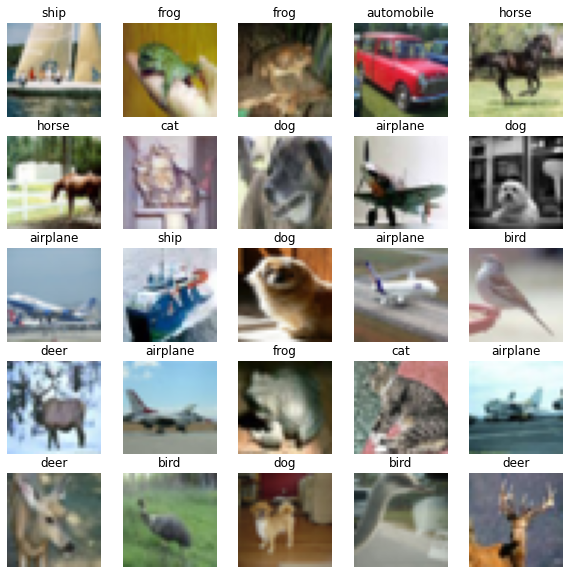

In [326]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [327]:
labels

(8, 6, 6, 1, 7, 7, 3, 5, 0, 5, 0, 8, 5, 0, 2, 4, 0, 6, 3, 0, 4, 2, 5, 2, 4)

In [328]:
torch.Tensor(labels)

tensor([8., 6., 6., 1., 7., 7., 3., 5., 0., 5., 0., 8., 5., 0., 2., 4., 0., 6.,
        3., 0., 4., 2., 5., 2., 4.])

A solution to this is to *renormalize* the images so each pixel is between $[0,1]$. This is done by clipping the pixel values between the maximum and minimum within an image and then scaling each pixel between $[0,1]$ using these maximum and minimums. 

As we can see the images below look a lot more like we were expecting, along with the rotations and cropping.

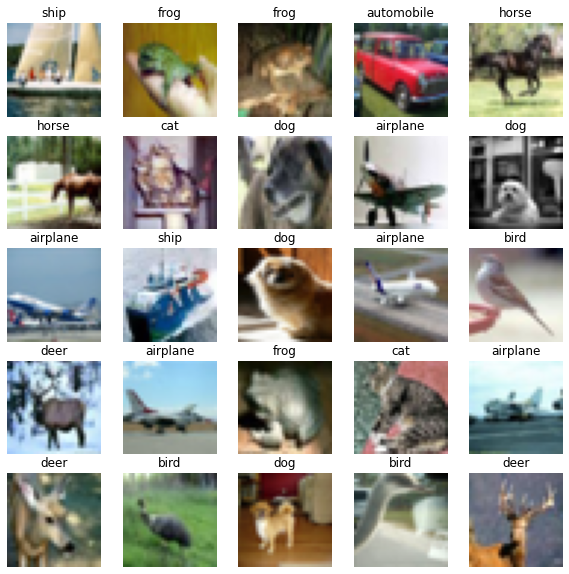

In [329]:
plot_images(images, labels, classes, normalize = True)

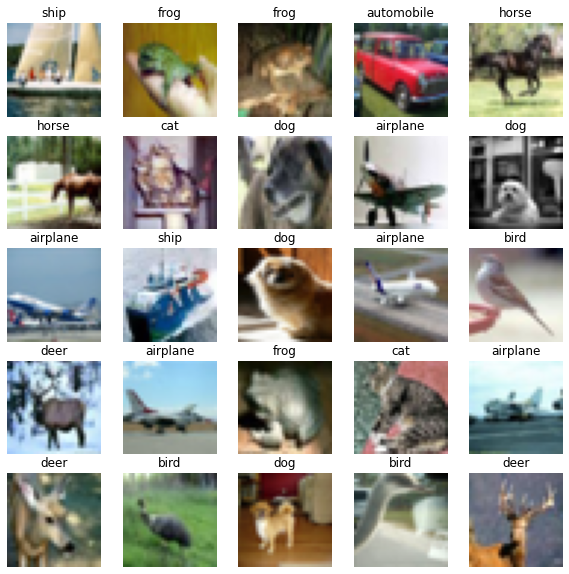

In [330]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels, test_data.classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [331]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

As before, we'll check what images look like with Sobel filters applied to them.

In [332]:
def plot_filter(images, filter, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)
    
    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)
        
        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Filtered')
        ax.axis('off');

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the `plot_filter` function.

Below is a filter which detects horizontal lines.

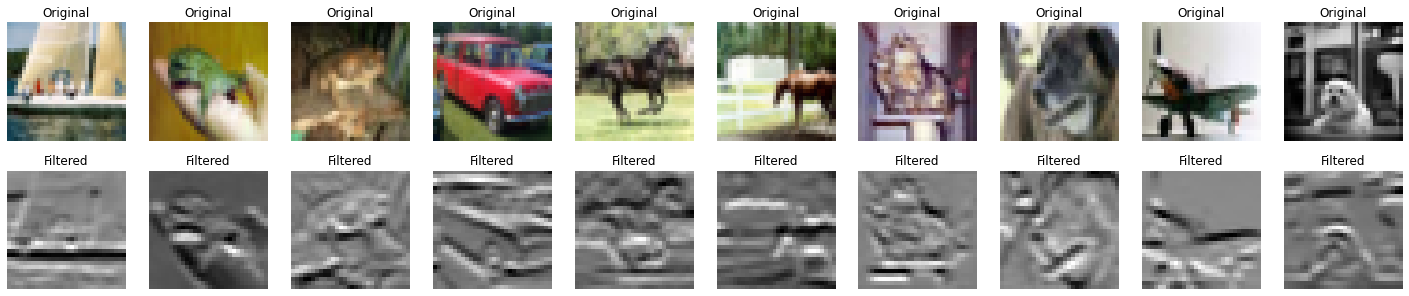

In [333]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Here's a filter that detects vertical lines.

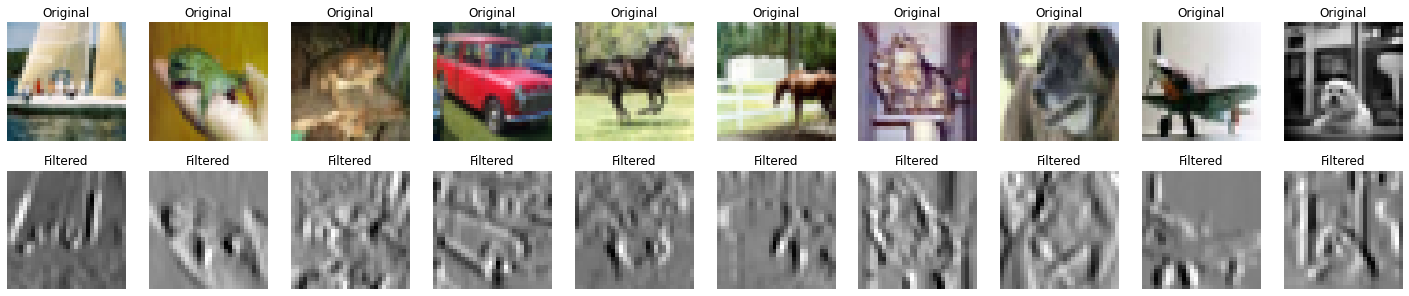

In [334]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

We'll also do the same for subsampling/pooling.

In [335]:
def plot_subsample(images, pool_type, pool_size, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
    
    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size = pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))
    
    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Subsampled')
        ax.axis('off');
        
    

As before, the higher filter sizes in the pooling layers means more information is lost, i.e. the image becomes lower resolution.

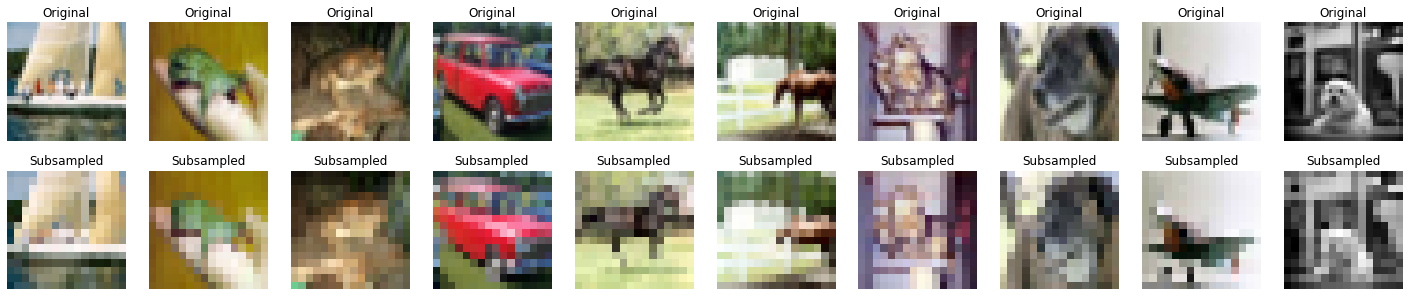

In [336]:
plot_subsample(images, 'max', 2)

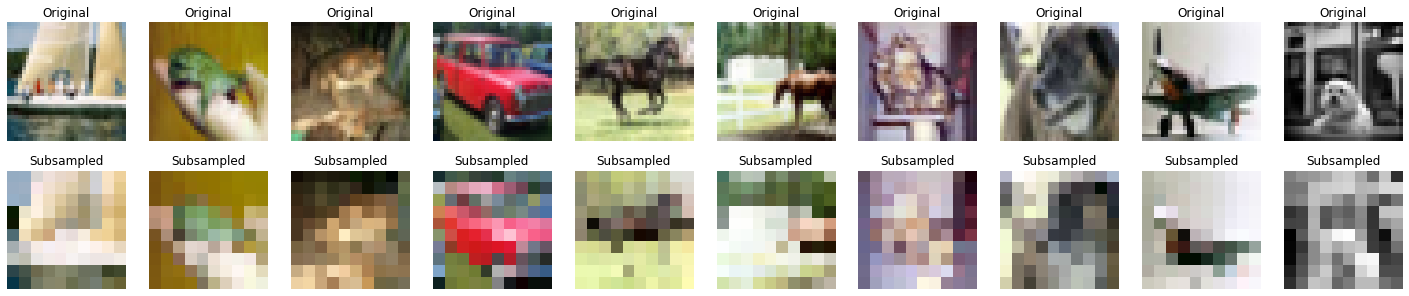

In [337]:
plot_subsample(images, 'max', 3)

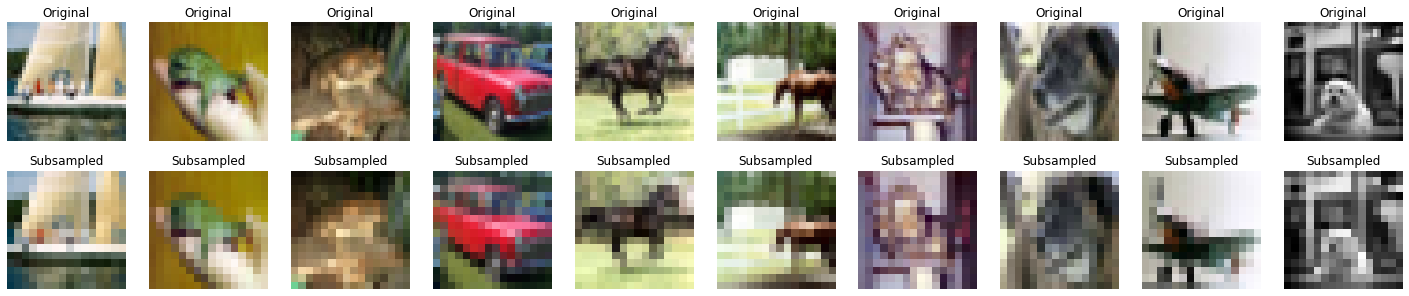

In [338]:
plot_subsample(images, 'avg', 2)

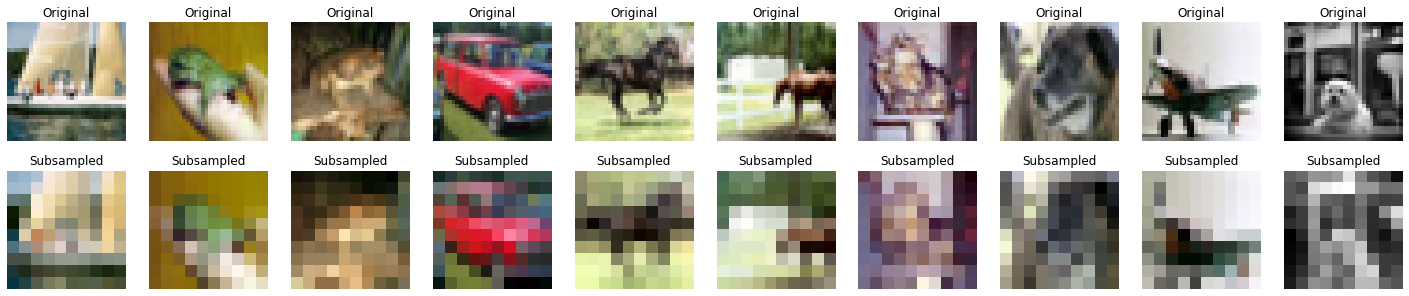

In [339]:
plot_subsample(images, 'avg', 3)

The final bit of the data processing is creating the iterators.

We use a much larger batch size here than in previous models. Generally, when using a GPU, a larger batch size means our model trains faster. Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer. We offset this as much as we can by using a batch size of 256 instead of 64.

In [340]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## plot cutmix, mixup, cutout

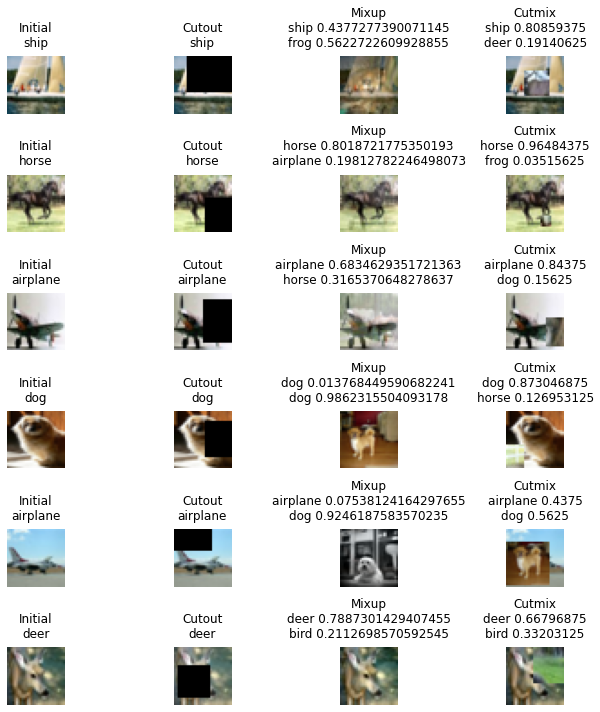

In [341]:
def plot_images(images, labels, classes, normalize = False):
    import copy
    def cutmix(image_batch, label_batch):
      lam = np.random.uniform()

      rand_index = torch.randperm(image_batch.size()[0])
      target_a = label_batch
      target_b = label_batch[rand_index]

      bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)
      image_batch[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]

      lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.size()[-1] * image_batch.size()[-2]))
      return image_batch, target_a, target_b, lam

    def mixup(image_batch, label_batch):
      lam = np.random.uniform()

      batch_size = image_batch.size()[0]
      index = torch.randperm(batch_size)

      image_batch = lam * image_batch + (1 - lam) * image_batch[index, :]
      target_a, target_b = label_batch, label_batch[index]
      return image_batch, target_a, target_b, lam

    def cutout(image_batch, label_batch):
      lam = np.random.uniform()
      bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)

      mask = torch.ones_like(image_batch)
      mask[:, :, bbx1:bbx2, bby1:bby2] = 0

      image_batch = image_batch * mask
      return image_batch, label_batch
    
    n_images = len(images)

    rows = int(n_images//4)
    cols = int(4)

    fig = plt.figure(figsize = (10, 10))
    image_batch_ini=torch.stack(images,dim=0)
    label_batch_ini=torch.Tensor(labels)
 
    PADDING_SIZE=10
    for i in range(0,rows*cols,4):
#     for i in range(0,4,4):
    
        #####initial
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title("Initial"+"\n"+classes[labels[i]],pad=PADDING_SIZE)
        ax.axis('off')

        ##### cutout
        image_batch, label_batch = cutout(copy.deepcopy(image_batch_ini), copy.deepcopy(label_batch_ini))
        ax = fig.add_subplot(rows, cols, i+2)
        image = image_batch[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
    
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title("Cutout"+"\n"+classes[label_batch[i].int()],pad=PADDING_SIZE)
        ax.axis('off')

        ###Mixup
        image_batch, target_a, target_b, lam = mixup(copy.deepcopy(image_batch_ini), copy.deepcopy(label_batch_ini))
        ax = fig.add_subplot(rows, cols, i+3)
        image = image_batch[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    #         ax.set_title(classes[labels[i]])
        ax.set_title("Mixup"+"\n"+classes[target_a[i].int()]+" "+str(lam)+"\n"+classes[target_b[i].int()]+" "+str(1-lam),pad=PADDING_SIZE)
        ax.axis('off')

        #####Cutmix
        image_batch, target_a, target_b, lam = cutmix(copy.deepcopy(image_batch_ini), copy.deepcopy(label_batch_ini))
        ax = fig.add_subplot(rows, cols, i+4)
        image = image_batch[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title("Cutmix"+"\n"+classes[target_a[i].int()]+" "+str(lam)+"\n"+classes[target_b[i].int()]+" "+str(1-lam),pad=PADDING_SIZE)
        ax.axis('off')
    fig.tight_layout()
    plt.show()
        
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes=test_data.classes
plot_images(images, labels, classes, normalize = True)

### Defining the Model

Next up is defining the model.

The actual model itself is no more difficult to understand than the previous model, LeNet. It is made up of convolutional layers, pooling layers and ReLU activation functions. See the previous notebook for a refresher on these concepts. 

There are only two new concepts introduced here, `nn.Sequential` and `nn.Dropout`.

We can think of `Sequential` as like our transforms introduced earlier for data augmentation. We provide `Sequential` with multiple layers and when the `Sequential` module is called it will apply each layer, in order, to the input. There is no difference between using a `Sequential` and having each module defined in the `__init__` and then called in `forward` - however it makes the code significantly shorter.

We have one `Sequential` model, `features`, for all of the convolutional and pooling layers, then we flatten then data and pass it to the `classifier`, another `Sequential` model which is made up of linear layers and the second new concept, *dropout*.

Dropout is a form of [*regularization*](https://en.wikipedia.org/wiki/Regularization_(mathematics)). As our models get larger, to perform more accurately on richer datasets, they start having a significantly higher number of parameters. The problem with lots of parameters is that our models begin to *overfit*. That is, they do not learn general image features whilst learning to classify images but instead simply memorize images within the training set. This is bad as it will cause our model to achieve poor performance on the validation/testing set. To solve this overfitting problem, we use regularization. Dropout is just one method of regularization, other common ones are *L1 regularization*, *L2 regularization* and *weight decay*.

Dropout works by randomly setting a certain fraction, 0.5 here, of the neurons in a layer to zero. This effectively adds noise to the training of the neural network and causes neurons to learn with "less" data as they are only getting half of the information from a previous layer with dropout applied. It can also be thought of as causing your model to learn multiple smaller models with less parameters. 

Dropout is only applied when the model is training. It needs to be "turned off" when validating, testing or using the model for inference.

As mentioned in the previous notebook, during the convolutional and pooling layers the activation function should be placed **after** the pooling layer to reduce computational cost.

In the linear layers, dropout should be applied **after** the activation function. Although when using ReLU activation functions the same result is achieved if dropout is before or after, see [here](https://sebastianraschka.com/faq/docs/dropout-activation.html).

One last thing to mention is that the very first convolutional layer has an `in_channel` of three. That is because we are handling color images that have three channels (red, green and blue) instead of the single channel grayscale images from the MNIST dataset. This doesn't change the way any of the convolutional filter works, it just means the first filter has a depth of three instead of a depth of one.

In [342]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

We'll create an instance of our model with the desired amount of classes.

In [343]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

Then we'll see how many trainable parameters our model has. 

Our LeNet architecture had ~44k, but here we have 23.2M parameters - and AlexNet is a relatively small model for computer vision.

In [344]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


### Training the Model

Next up, we'll initialize the parameters of our model.

PyTorch's default initialization is usually fine however by manually trying different initialization schemes we can usually squeeze out a slight performance improvement.

We initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the `nn.init` methods to actually initialize the parameters.

For our convolutional layers, we'll initialize the weights from a Normal distribution with a standard deviation given by:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

The value of $\text{gain}$ depends on the non-linearity we will be using after the convolutional layer and we simply tell the initialization function that we are using ReLU which sets the gain to $\sqrt{2}$. The fan mode can be either `fan_in` or `fan_out`. `fan_in` is the number of connections coming into the layer and `fan_out` is the number of connections going out of the layer. For the first convolutional layer the input is from 3x3x3 filter, so the `fan_in` is 27 and the output is 64x3x3,  so the `fan_out` is 576. We leave it to the default `fan_in` mode. This initialization scheme is called *Kaiming Normal*, also known as *He Normal*. See the [paper](https://arxiv.org/abs/1502.01852) to learn more about how it was devised.

For the linear layers we initialize with a Normal distribution but this time the standard deviation is given by:

$$\text{gain} \times \sqrt{\frac{2}{\text{fan_in} + \text{fan_out}}}$$

Confusingly, instead of just telling the initialization function which non-linearity we want to use and have it calculate the gain for us, we have to tell it what gain we want to use. Luckily, `nn.init` has a `calculate_gain` function which does that for us, and we just tell it we are using ReLUs. This type of initialize scheme is called *Xavier Normal*, also known as *Glorot Normal*. See the [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for the theory behind it. 

For both types of layer we initialize the bias terms to zeros.

Why do we even need to initialize our parameters this way? See [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79) article for a great explanation, but the gist of it is that just like how we normalized our input data to have a mean of 0 and a standard deviation of 1, we also want the outputs of each activation function (and therefore the inputs to the subsequent layer) to also have a mean of 0 and a standard deviation of 1. These initialization schemes, by taking account the number of connections in to and out of a layer as well as the non-linearity used, help achieve this normalization effect when initializing weights.

In [345]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's `apply` method. This will call the given function on every module and sub-module within the model.

In [346]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

Next up is the learning rate finder. The code here is taken from a stripped down and slightly modified version of the excellent [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 

**Note**: the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us 100% accuracy - but it is usually going to be better than just picking a learning rate out of thin air.  

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate. 

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated. 

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.

In [347]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [348]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)

criterion = criterion.to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test` with the training iterator, the maximum learning rate and the number of iterations we want to use. 

In [349]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we can plot the learning rate against the loss. 

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [350]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before reaching a minimum and starting to increase. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

In [351]:
# plot_lr_finder(lrs, losses)

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [352]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [353]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [354]:
def train(model, iterator, optimizer, criterion, device, epoch, reg="None"):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    count=0
    for (x, y) in iterator:
        optimizer.zero_grad()
        image_batch=x.to(device)
        label_batch=y.to(device)
        image_batch.to(device)
        if reg == 'cutmix':
            image_batch, target_a, target_b, lam = cutmix(image_batch, label_batch)
            y_pred,_ = model(image_batch)
            batch_loss = criterion(y_pred, target_a) * lam + criterion(y_pred, target_b) * (1. - lam)
        elif reg == 'mixup':
            image_batch, target_a, target_b, lam = mixup(image_batch, label_batch)
            y_pred,_ = model(image_batch)
            batch_loss = lam * criterion(y_pred, target_a) + (1 - lam) * criterion(y_pred, target_b)
        elif reg == 'cutout':
            image_batch, label_batch = cutout(image_batch, label_batch)
            y_pred,_ = model(image_batch)
            batch_loss = criterion(y_pred, label_batch)
        else:
            y_pred, _ = model(image_batch)
            batch_loss = criterion(y_pred, label_batch)
        
        acc = calculate_accuracy(y_pred, label_batch)
        
        batch_loss.backward()
        
        optimizer.step()
        
        epoch_loss += batch_loss.item()
        epoch_acc += acc.item()
        count+=1
        writer.add_scalar(f'{REG_method} Batch/Train/loss', batch_loss, epoch*len(iterator) + count)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [355]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Next, we define a function to tell us how long an epoch takes.

In [356]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

We get a best validation loss of ~76% accuracy.

In [357]:

EPOCHS = 200

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device, epoch,reg=REG_method)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    writer.add_scalar(f'{REG_method} Epoch/Train/loss', train_loss, epoch)
    writer.add_scalar(f'{REG_method} Epoch/Train/accuracy', train_acc, epoch)
    writer.add_scalar(f'{REG_method} Epoch/Valid/loss', valid_loss, epoch)
    writer.add_scalar(f'{REG_method} Epoch/Valid/accuracy', valid_acc, epoch)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 2.175 | Train Acc: 18.91%
	 Val. Loss: 1.631 |  Val. Acc: 39.29%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.847 | Train Acc: 27.59%
	 Val. Loss: 1.530 |  Val. Acc: 45.99%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.705 | Train Acc: 31.11%
	 Val. Loss: 1.269 |  Val. Acc: 54.94%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.663 | Train Acc: 31.48%
	 Val. Loss: 1.252 |  Val. Acc: 57.45%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.611 | Train Acc: 37.22%
	 Val. Loss: 1.117 |  Val. Acc: 61.87%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.550 | Train Acc: 37.03%
	 Val. Loss: 1.114 |  Val. Acc: 62.35%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.535 | Train Acc: 35.61%
	 Val. Loss: 1.041 |  Val. Acc: 64.91%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 1.461 | Train Acc: 38.09%
	 Val. Loss: 1.101 |  Val. Acc: 64.99%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 1.452 | Train Acc: 38.46%
	 Val. Loss: 1.017 |  Val. Acc: 66.33%
Epoch: 10 | Epoch T

Epoch: 77 | Epoch Time: 0m 11s
	Train Loss: 1.054 | Train Acc: 46.07%
	 Val. Loss: 0.939 |  Val. Acc: 72.64%
Epoch: 78 | Epoch Time: 0m 10s
	Train Loss: 1.077 | Train Acc: 54.00%
	 Val. Loss: 0.937 |  Val. Acc: 72.33%
Epoch: 79 | Epoch Time: 0m 10s
	Train Loss: 1.012 | Train Acc: 50.79%
	 Val. Loss: 0.948 |  Val. Acc: 71.92%
Epoch: 80 | Epoch Time: 0m 10s
	Train Loss: 1.014 | Train Acc: 52.26%
	 Val. Loss: 0.943 |  Val. Acc: 72.73%
Epoch: 81 | Epoch Time: 0m 10s
	Train Loss: 1.056 | Train Acc: 52.98%
	 Val. Loss: 0.997 |  Val. Acc: 70.82%
Epoch: 82 | Epoch Time: 0m 10s
	Train Loss: 1.059 | Train Acc: 52.82%
	 Val. Loss: 0.943 |  Val. Acc: 72.50%
Epoch: 83 | Epoch Time: 0m 10s
	Train Loss: 1.084 | Train Acc: 51.95%
	 Val. Loss: 0.913 |  Val. Acc: 73.30%
Epoch: 84 | Epoch Time: 0m 10s
	Train Loss: 1.085 | Train Acc: 53.60%
	 Val. Loss: 0.960 |  Val. Acc: 71.51%
Epoch: 85 | Epoch Time: 0m 9s
	Train Loss: 1.015 | Train Acc: 51.72%
	 Val. Loss: 0.945 |  Val. Acc: 72.09%
Epoch: 86 | Epoch Ti

Epoch: 152 | Epoch Time: 0m 10s
	Train Loss: 1.045 | Train Acc: 53.75%
	 Val. Loss: 0.940 |  Val. Acc: 72.31%
Epoch: 153 | Epoch Time: 0m 10s
	Train Loss: 1.049 | Train Acc: 52.17%
	 Val. Loss: 0.937 |  Val. Acc: 72.87%
Epoch: 154 | Epoch Time: 0m 10s
	Train Loss: 1.044 | Train Acc: 54.56%
	 Val. Loss: 0.949 |  Val. Acc: 72.02%
Epoch: 155 | Epoch Time: 0m 9s
	Train Loss: 1.017 | Train Acc: 53.86%
	 Val. Loss: 0.907 |  Val. Acc: 73.06%
Epoch: 156 | Epoch Time: 0m 9s
	Train Loss: 1.046 | Train Acc: 54.19%
	 Val. Loss: 0.932 |  Val. Acc: 72.90%
Epoch: 157 | Epoch Time: 0m 9s
	Train Loss: 1.041 | Train Acc: 50.25%
	 Val. Loss: 0.938 |  Val. Acc: 71.88%
Epoch: 158 | Epoch Time: 0m 9s
	Train Loss: 1.017 | Train Acc: 51.72%
	 Val. Loss: 0.950 |  Val. Acc: 72.59%
Epoch: 159 | Epoch Time: 0m 11s
	Train Loss: 0.980 | Train Acc: 50.91%
	 Val. Loss: 0.939 |  Val. Acc: 72.43%
Epoch: 160 | Epoch Time: 0m 9s
	Train Loss: 1.033 | Train Acc: 52.31%
	 Val. Loss: 0.932 |  Val. Acc: 72.44%
Epoch: 161 | Ep

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~75% accuracy.

In [358]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.881 | Test Acc: 70.71%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all of the predictions.

In [359]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [360]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [361]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [362]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

The two classes our model seems to get mixed up the most is cat and dog.

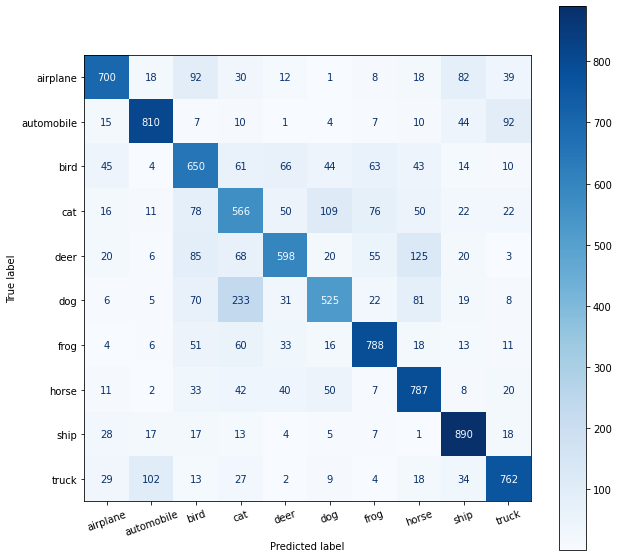

In [363]:
plot_confusion_matrix(labels, pred_labels, classes) 

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [364]:
corrects = torch.eq(labels, pred_labels)

In [365]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [366]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Interestingly the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

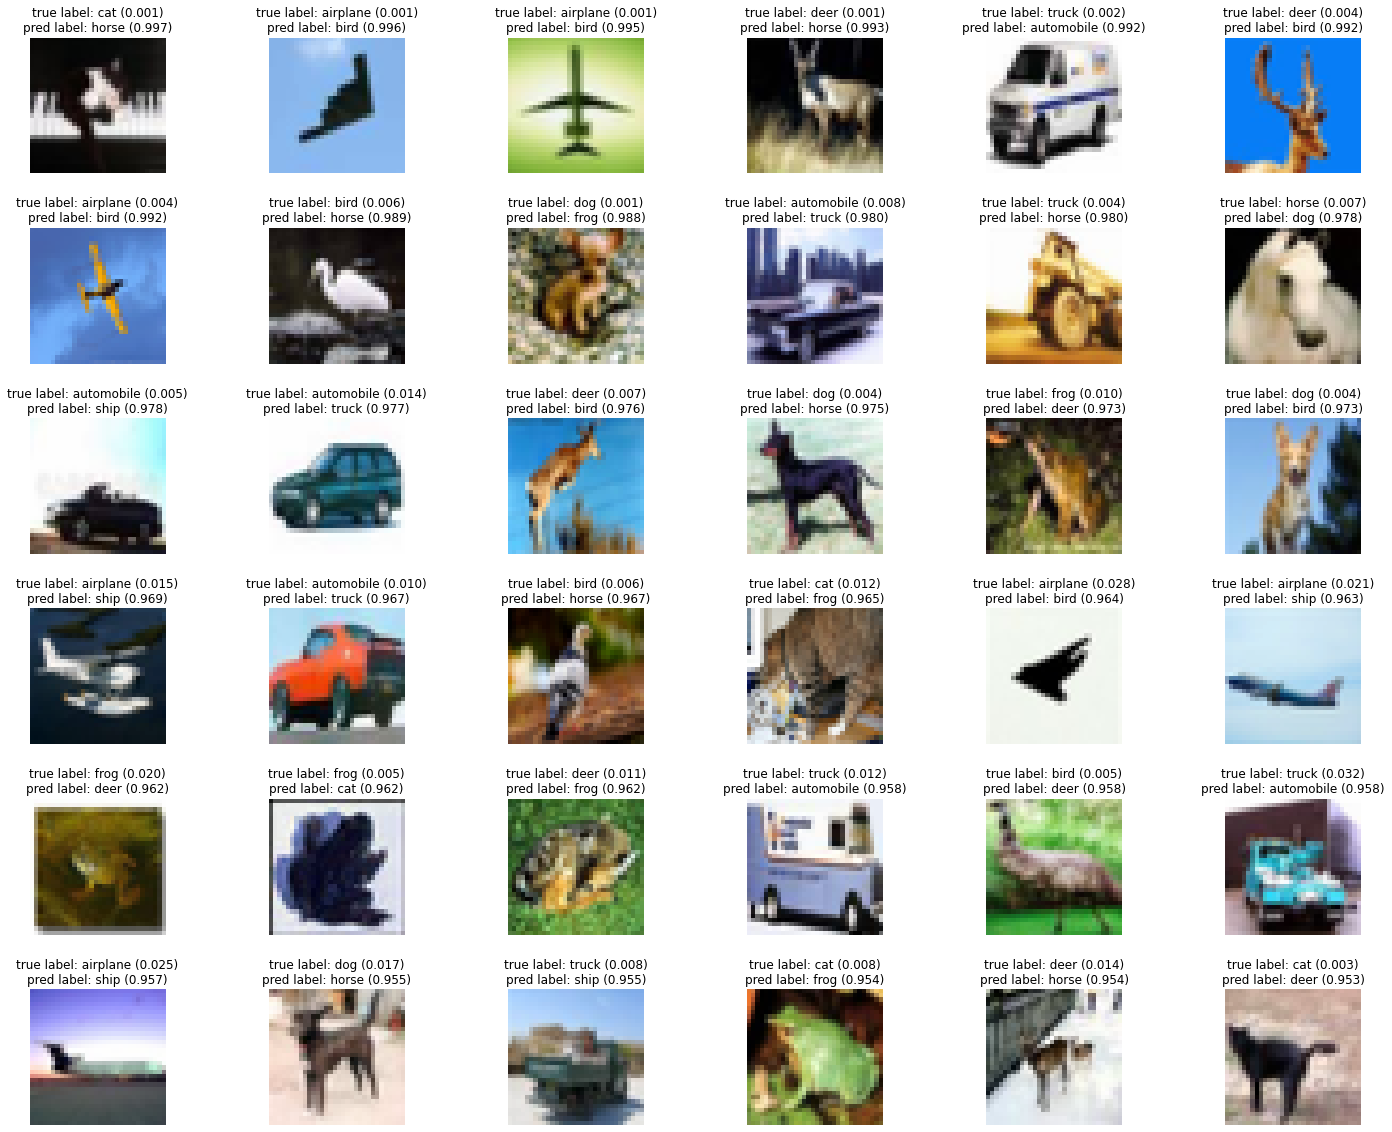

In [367]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [368]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

In [369]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)

We can then perform PCA on them both and plot them.

In [370]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [371]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

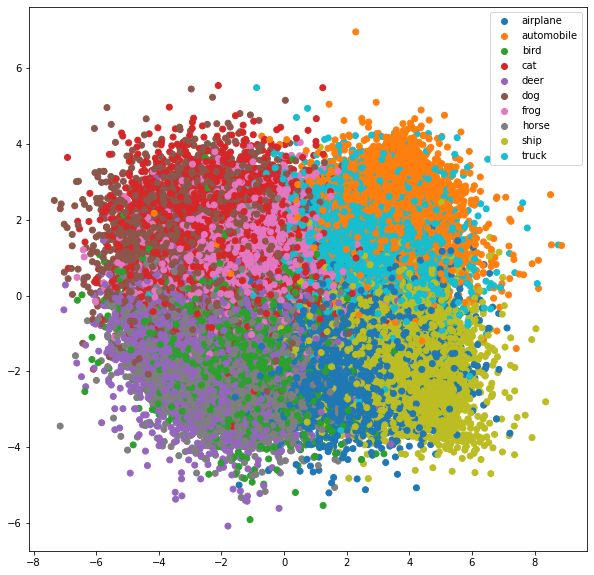

In [372]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

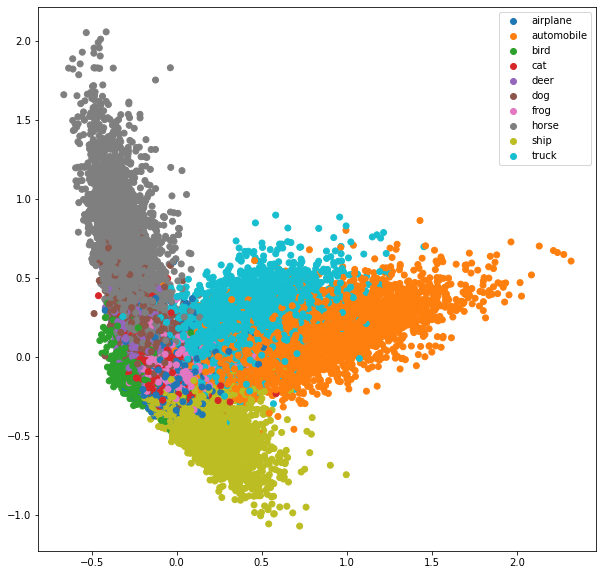

In [373]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [374]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

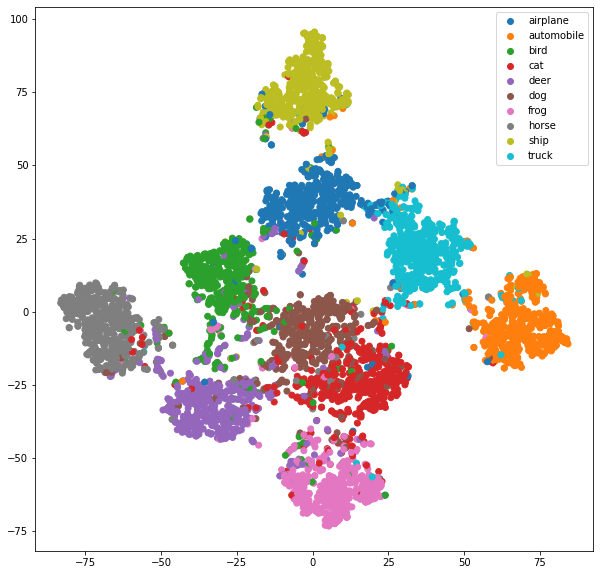

In [375]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES)

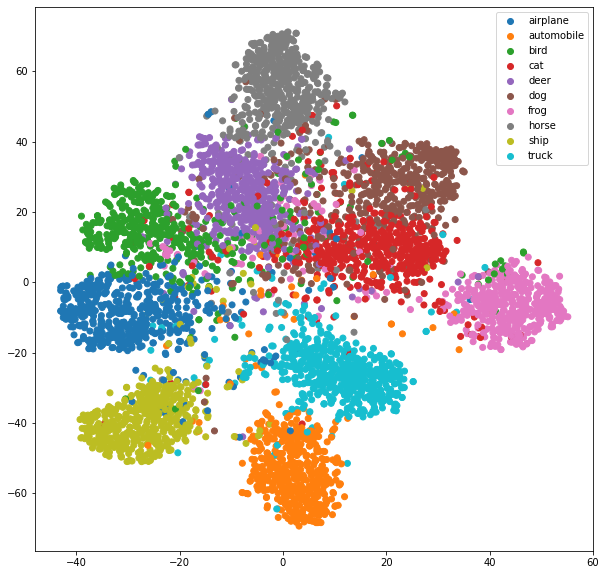

In [376]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images = N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [377]:
def imagine_image(model, classes, image, device, n_iterations = 10_000):

    model.eval()
    
    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():
    
        for _ in range(n_iterations):

            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim = -1)

            _best_prob, index = torch.max(preds[:,label], dim = 0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [378]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [379]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


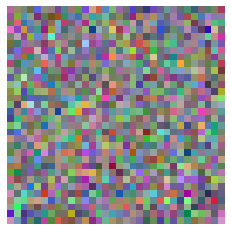

In [380]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1,2,0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [381]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

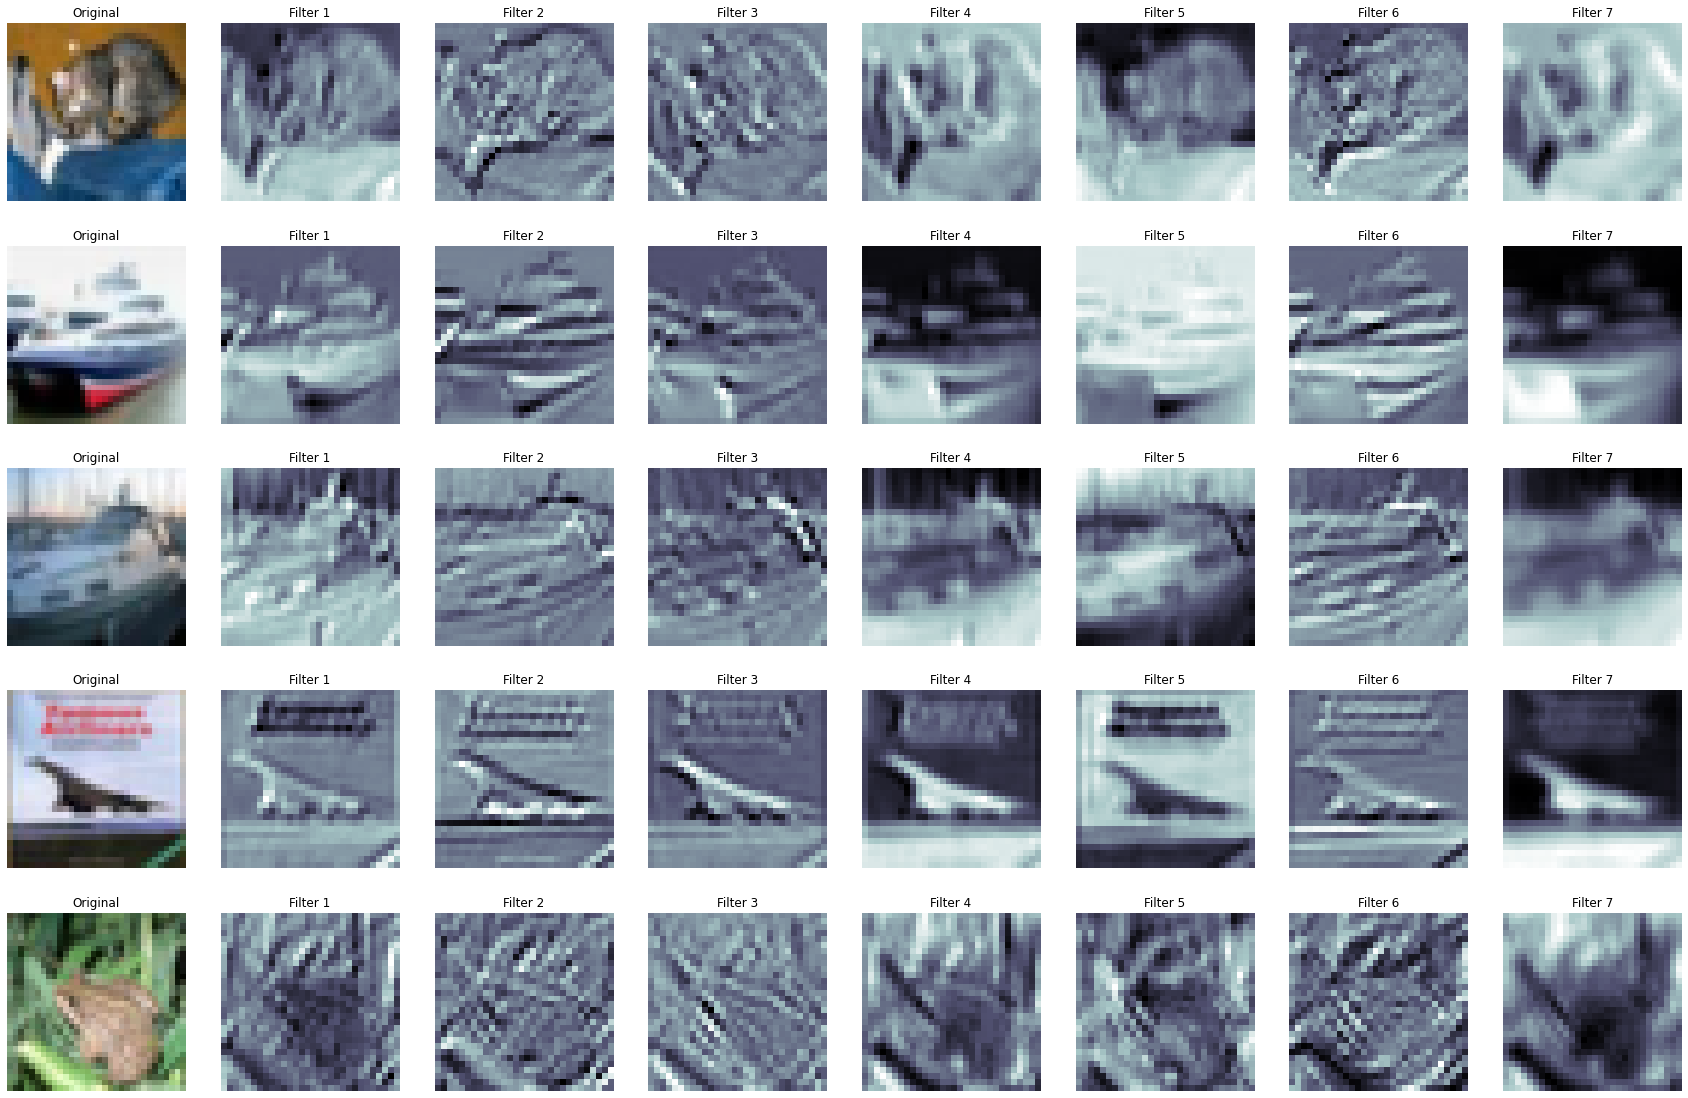

In [382]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [383]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

Again, nothing really interpretable here, sadly.

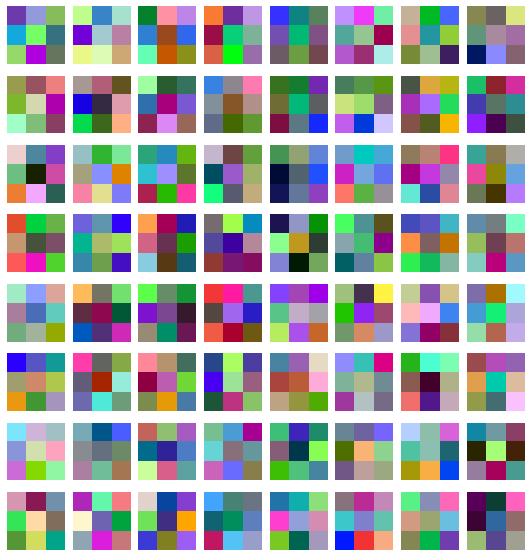

In [384]:
plot_filters(filters)

Can we ever learn interesting looking filters? Or are we doomed to just look at colorful blocks forever?

Well, we can take a *pre-trained* AlexNet model and view the filters of that. This pre-trained version of AlexNet was trained by people at PyTorch and was not trained on the CIFAR10 dataset, but on the [ILSVRC](https://arxiv.org/abs/1409.0575) dataset, usually just called the ImageNet dataset. ImageNet is a dataset with over 1 million images in 1,000 classes. Torchvision provides ways of downloading different models pre-trained on ImageNet, such as AlexNet and [many others](https://pytorch.org/docs/stable/torchvision/models.html).  

First, we can import the model making sure to pass `pretrained = True` to get a pre-trained version. Torchvision will then import the model, download the weights for it and load them into the new model.

We can see that this is similar to our AlexNet model but has considerably more parameters.

One interesting thing is that they use much larger filters in the first convolutional layer - 11x11 instead of 3x3.

In [385]:
# import torchvision.models as models

# model = models.alexnet(pretrained = True)

# print(model)

We can then get the learned values of these filters the same way we did for our version of AlexNet and then plot them.

As we can see the patterns are much more interesting, though still not really interpretable.

So how come it learned these interesting looking filters? Is it just because the filters are bigger? Is it because models can only do well on ImageNet if they learn more interesting filters? Or something else?

Do more interesting looking filters imply that they perform better? Or are these filters showing how the model has overfit to patterns on the images within ImageNet?

It is difficult to answer these questions as modern computer vision architectures now seem to favour smaller filter sizes with their largest filters being 5x5 - so maybe larger filters aren't that good after all?

In [386]:
# filters = model.features[0].weight.data

# plot_filters(filters)

In [387]:
writer.close()

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (AlexNet)
- custom weight initialization
- how to use the learning rate finder
- training a model to achieve >75% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake images
- viewing the learned weights of our model
- loading a pre-trained model

In the next notebook we'll implement a popular CNN architecture, VGG, and learn about how to actually use pre-trained models on our dataset.